In [1]:
!pip install pyreadr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras
import keras.optimizers as optimizers
from keras import layers, callbacks
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_squared_error as mse
import pyreadr
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from scipy.stats import norm
import random

### PCA Class

In [3]:
class CreateModel:
    def __init__(self, data):
        self.samples = data.shape[0]
        self.timestamps = data.shape[1]
        self.features = data.shape[2]

    def flatten(self, data):
        return data.reshape(self.samples * self.timestamps, self.features)

    def reshape(self, data):
        return data.reshape(self.samples, self.timestamps, self.features)

    def fit_pca(self, data, n_components):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

        data = self.flatten(data)
        self.pca.fit(data)
        data_pca = self.pca.transform(data)
        data_rec = self.pca.inverse_transform(data_pca)
        data_rec = self.reshape(data_rec)
        return data_rec

    def evaluate_pca(self, n_data, n_data_rec, f_data, pca_threshold=None):
        if pca_threshold == None:
            self.pca_threshold = np.max(np.mean(np.abs(n_data - n_data_rec), axis=1))
        else:
            self.pca_threshold = pca_threshold
        f_data = self.flatten(f_data)
        f_data_pca = self.pca.transform(f_data)
        self.f_data_rec = self.pca.inverse_transform(f_data_pca)
        self.f_data_rec = self.reshape(self.f_data_rec)
        f_data = self.reshape(f_data)

        self.pca_error = np.mean(np.abs(f_data - self.f_data_rec), axis=1)

        result = []
        self.pca_anomaly = []
        for i in range(len(self.pca_error)):
            anomalies = self.pca_error[i,] > self.pca_threshold
            if np.sum(anomalies >= 1):
                self.pca_anomaly.append((i, np.where(self.pca_error[i] > self.pca_threshold)))
                result.append(1)
            else:
                result.append(0)
        return np.sum(np.array(result))

    def get_f_rec(self):
        return self.f_data_rec

    def fit_ae(self, data):
        self.model = keras.Sequential(
            [
                layers.Dense(256, input_shape=(data.shape[1], data.shape[2]), activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(32, activation='relu'),
                layers.Dense(64, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(data.shape[2])
            ]
        )
        self.model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

        history = self.model.fit(
            data,
            data,
            epochs=50,
            batch_size=128,
            validation_split=0.1,
            verbose=0
        )

        predictions = self.model.predict(data)
        return predictions

    def evaluate_ae(self, n_data, n_data_rec, f_data, ae_threshold=None):
        if ae_threshold == None:
            self.ae_threshold = np.max(np.mean(np.abs(n_data - n_data_rec), axis=1))
        else:
            self.ae_threshold = ae_threshold
        self.f_data_rec = self.model.predict(f_data, verbose=0)
        self.ae_error = np.mean(np.abs(f_data - self.f_data_rec), axis=1)

        result = []
        self.ae_anomaly = []
        for i in range(len(self.ae_error)):
            anomalies = self.ae_error[i,] > self.ae_threshold
            if np.sum(anomalies >= 1):
                self.ae_anomaly.append((i, np.where(self.ae_error[i] > self.ae_threshold)))
                result.append(1)
            else:
                result.append(0)
        return np.sum(np.array(result))

    def plot(self, n_data, n_data_rec, f_data, f_data_rec, sample, feature):
        plt.figure(figsize=(12, 12))
        plt.subplot(211)
        plt.title(f"Normal Data Mean Absolute Error: {mae(n_data[sample][:, feature], n_data_rec[sample][:, feature])}")
        plt.plot(n_data[sample][:, feature])
        plt.plot(n_data_rec[sample][:, feature])
        plt.subplot(212)
        plt.title(f"Faulty Data Mean Absolute Error: {mae(f_data[sample][:, feature], f_data_rec[sample][:, feature])}")
        plt.plot(f_data[sample][:, feature])
        plt.plot(f_data_rec[sample][:, feature])
        plt.show()

#### Normal Data

In [4]:
class DataCreation:
    def __init__(self):
        pass

    def create_feature(self, function, mean, variance, co_ef, intercept, freq):
        x = co_ef * function(np.linspace(0, freq*np.pi, 1000)) + intercept
        x = x + np.random.normal(mean, variance, 1000)
        return x

    def create_samples(self, num_samples, features, seed):
        self.num_samples = num_samples
        self.features = features
        self.X = []

        for i in range(num_samples):
            d = {}
            random.seed(seed)
            for j in range(features):

                freq = random.choice([10, 20, 30, 40, 50])
                co_ef = random.randint(1, 10)
                intercept = random.uniform(0, 500)
                mean = 0
                variance = random.uniform(0.1, 2)
                function = random.choice([np.sin, np.cos])

                d[f'x_{j}'] = self.create_feature(function, mean, variance, co_ef, intercept, freq)
            training = pd.DataFrame(d)
            self.X.append(training)
        self.X = np.array(self.X)
        return self.X

    def normalize(self, data):
        scaler = MinMaxScaler()
        for i in range(len(data)):
            data[i] = scaler.fit_transform(data[i])
        return data

    def plot_feature(self, data, sample, feature):
        plt.figure(figsize=(12, 6))
        plt.plot(data[sample][:,feature])
        plt.show()
        pass

In [5]:
features = 50
samples = 1000

In [6]:
n_data = DataCreation()
n_train_X = n_data.create_samples(samples, features, 2)
n_train_X = n_data.normalize(n_train_X)
n_train_X.shape

(1000, 1000, 50)

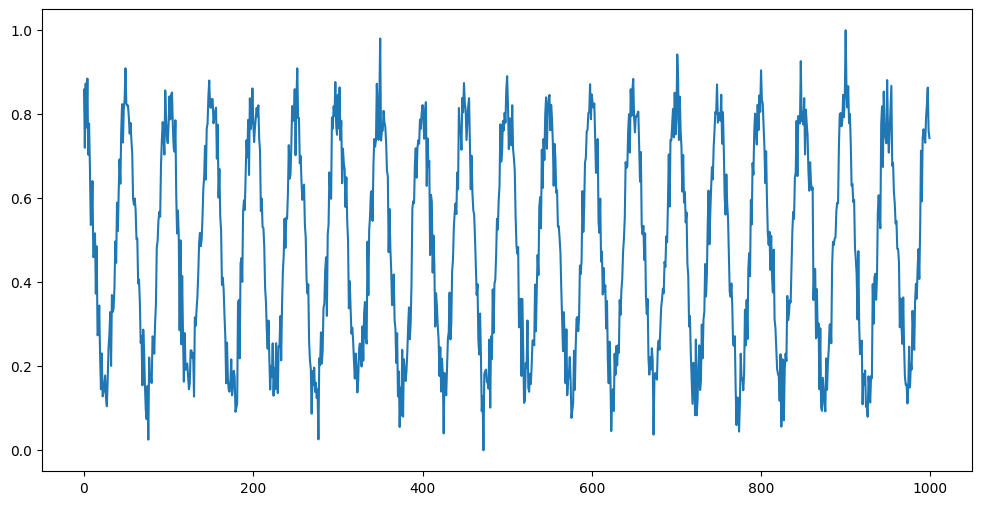

In [21]:
n_data.plot_feature(n_train_X, 0, 49)

#### Faulty Data: Point Anomaly

In [7]:
f_data = DataCreation()
f_train_X = f_data.create_samples(samples, features, 2)
f_train_X.shape

(1000, 1000, 50)

In [8]:
random.seed(1000)
for i in range(samples):
    rand_feature = random.choice([i for i in range(features)])
    rand_timestamp = random.choice([i for i in range(1000)])
    f_train_X[i][rand_timestamp, rand_feature] = np.mean(f_train_X[i][:,rand_feature]) + 3*np.std(f_train_X[i][:,rand_feature])
f_train_X = f_data.normalize(f_train_X)

In [9]:
random.seed(1000)
for i in range(10):
    print(random.choice([i for i in range(features)]), random.choice([i for i in range(1000)]))

49 439
42 778
6 403
22 64
29 169
34 447
8 227
42 246
23 695
31 207


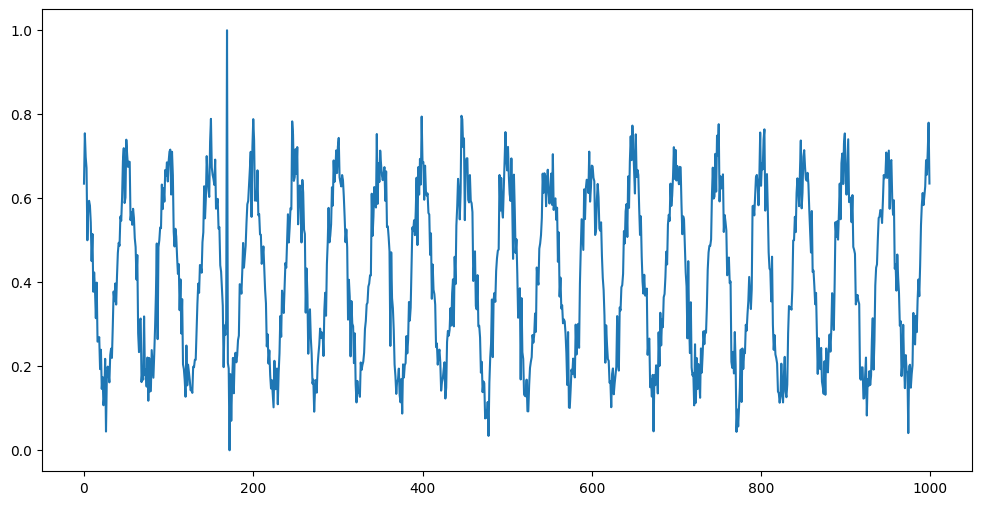

In [25]:
f_data.plot_feature(f_train_X, 4, 29)

In [10]:
n_data1 = DataCreation()
n_test = n_data1.create_samples(samples, features, 2)
n_test = n_data1.normalize(n_test)

In [26]:
pca = CreateModel(n_train_X)
n_train_rec = pca.fit_pca(n_train_X, 25)
# anomaly_faulty = []
# anomaly_normal = []
# p, r, f1 = [], [], []
# for i in range(1, 100):
#     threshold = 0.001 * i
#     tp = pca.evaluate_pca(n_train_X, n_train_rec, f_train_X, threshold)
#     fp = pca.evaluate_pca(n_train_X, n_train_rec, n_test, threshold)
#     tn = samples - fp
#     fn = samples - tp
#     anomaly_normal.append(fp)
#     anomaly_faulty.append(tp)
#     precision = tp / (tp + fp)
#     recall = tp / (tp + fn)
#     p.append(precision)
#     r.append(recall)
#     f1.append(2 * ((precision * recall) / (precision + recall)))
# anomaly_faulty

In [ ]:
plt.title(f"Threshold Value: {0.001 * f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [i*0.001 for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [32]:
r = np.array(r)
p = np.array(p)
diff = r - p
np.where(diff < 0)

(array([60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
        77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93,
        94, 95, 96, 97, 98]),)

In [27]:
threshold = 0.063
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, f_train_X, threshold)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.pca_threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, n_test, threshold)
n_test_rec = pca.get_f_rec()
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.063
Total Anomalies out of 1000: 684
Total Anomalies out of 1000: 140


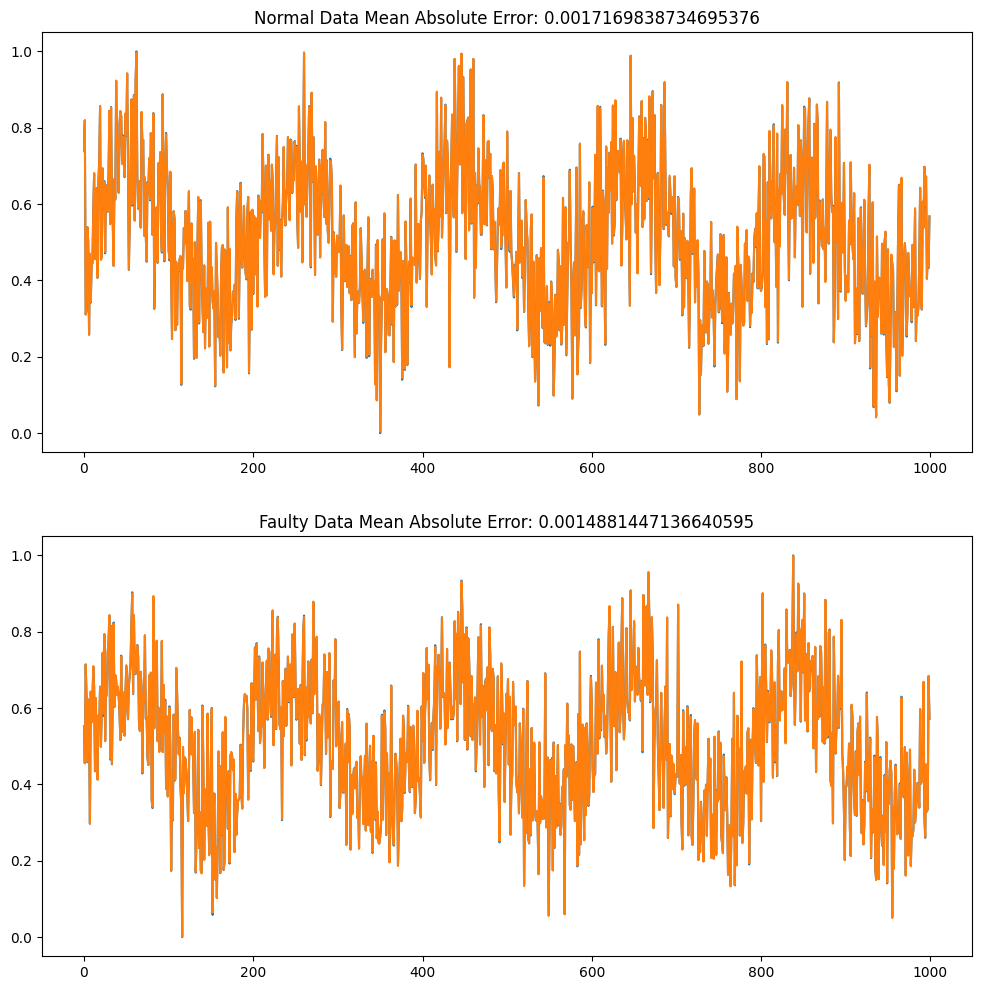

In [28]:
pca.plot(n_train_X, n_train_rec, n_test, n_test_rec, 0, 21)

In [ ]:
ae = CreateModel(n_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomaly_faulty = []
anomaly_normal = []
p, r, f1 = [], [], []
for i in range(1, 100):
    threshold = 0.001 * i
    tp = ae.evaluate_ae(n_train_X, n_train_rec, f_train_X, threshold)
    fp = ae.evaluate_ae(n_train_X, n_train_rec, n_test, threshold)
    tn = samples - fp
    fn = samples - tp
    anomaly_normal.append(fp)
    anomaly_faulty.append(tp)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    p.append(precision)
    r.append(recall)
    f1.append(2 * ((precision * recall) / (precision + recall)))
anomaly_faulty

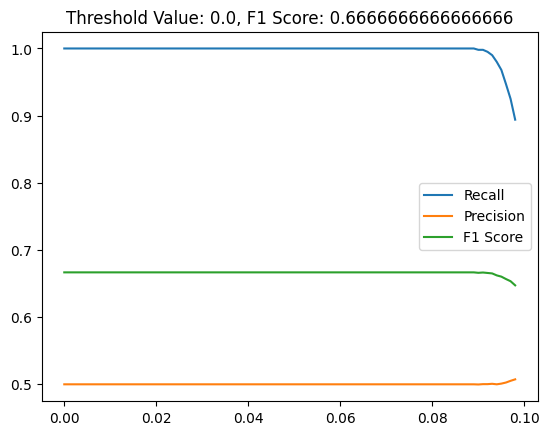

In [12]:
plt.title(f"Threshold Value: {0.001 * f1.index(max(f1))}, F1 Score: {max(f1)}")
x = [i*0.001 for i in range(len(r))]
plt.plot(x, r, label="Recall")
plt.plot(x, p, label="Precision")
plt.plot(x, f1, label="F1 Score")
plt.legend()
plt.show()

In [50]:
r = np.array(r)
p = np.array(p)
diff = r - p
np.where(diff < 0)

(array([83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]),)

In [56]:
f1[74]

0.6691399662731871

In [22]:
threshold = 0.083
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, f_train_X, threshold)
f_train_rec = ae.get_f_rec()
print(f"Threshold Value: {ae.ae_threshold}")
print(f"Total Anomalies out of {ae.samples}: {anomalies}")
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, n_test, threshold)
n_test_rec = ae.get_f_rec()
print(f"Total Anomalies out of {ae.samples}: {anomalies}")

Threshold Value: 0.083
Total Anomalies out of 1000: 1000
Total Anomalies out of 1000: 1000


In [38]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == ae.ae_threshold)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
ae.ae_anomaly

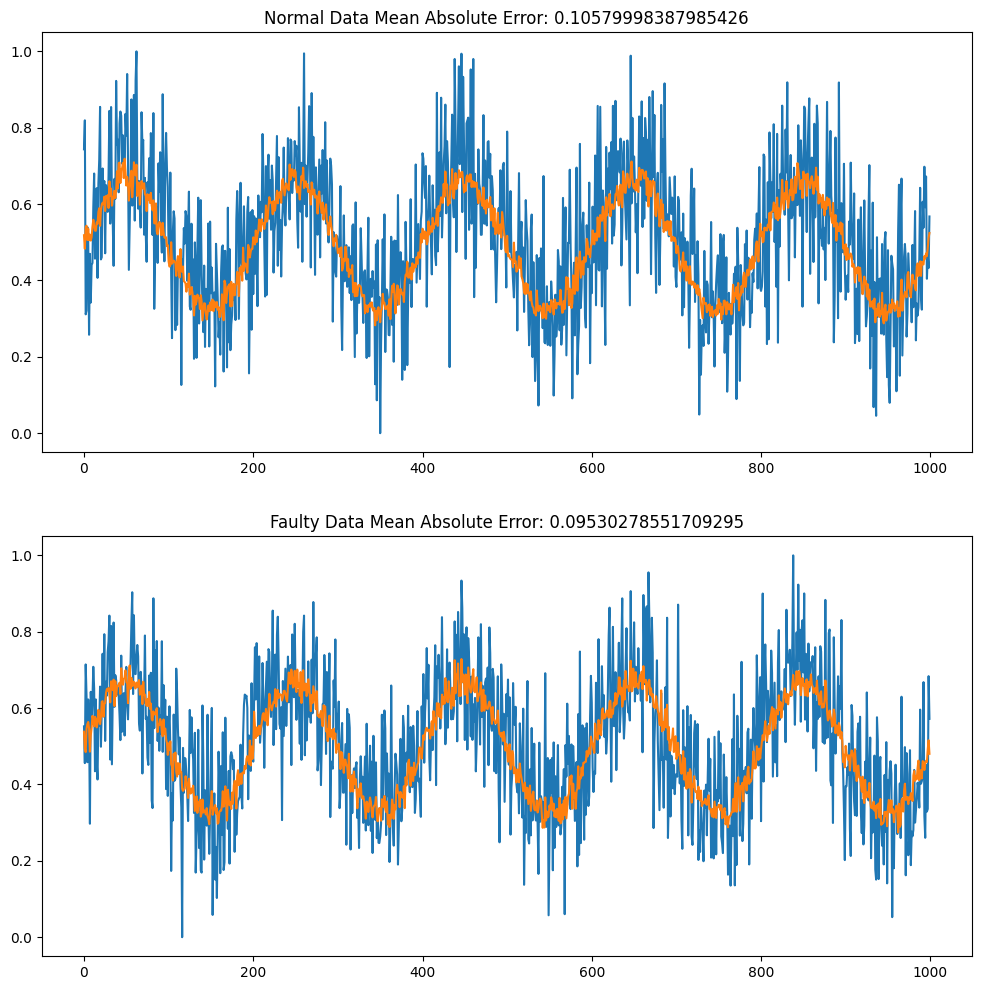

In [24]:
ae.plot(n_train_X, n_train_rec, n_test, n_test_rec, 0, 21)

#### Faulty Data: Collective Anomalies

In [ ]:
n_data = DataCreation()
n_train_X = n_data.create_samples(samples, features, 2)
n_train_X = n_data.normalize(n_train_X)

f_data = DataCreation()
f_train_X = f_data.create_samples(samples, features, 2)
f_train_X.shape

(1000, 1000, 50)

In [ ]:
random.seed(1001)
for i in range(samples):
    rand_feature = random.choice([i for i in range(features)])
    rand_timestamp = random.choice([i for i in range(970)])
    f_train_X[i][rand_timestamp:rand_timestamp+20, rand_feature] = f_train_X[i][rand_timestamp, rand_feature]
f_train_X = f_data.normalize(f_train_X)

In [ ]:
random.seed(1001)
for i in range(10):
    print(random.choice([i for i in range(50)]), random.choice([i for i in range(998)]))

3 778
48 202
5 568
24 804
10 416
46 383
36 664
49 410
49 585
12 622


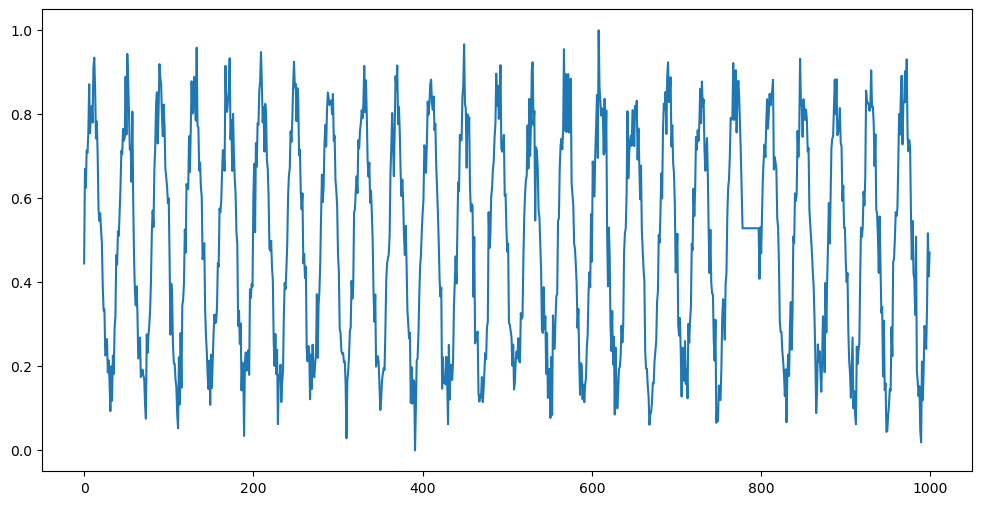

In [ ]:
f_data.plot_feature(f_train_X, 0, 3)

In [ ]:
pca = CreateModel(n_train_X)
n_train_rec = pca.fit_pca(n_train_X, 15)
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.pca_threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: [0.00574861 0.02820203 0.0614834  0.05711083 0.05555175 0.05363096
 0.00011325 0.05943107 0.05590609 0.05000716 0.06024336 0.05613618
 0.07109575 0.05934432 0.05129259 0.06086316 0.10396666 0.02994284
 0.03099282 0.07379287 0.06336138 0.09894065 0.09426908 0.05927595
 0.00187537 0.04324381 0.05213786 0.07818859 0.06810646 0.06584728
 0.05788492 0.05932971 0.08799778 0.03709032 0.08512072 0.06186742
 0.02828017 0.07388261 0.07495295 0.03710543 0.05781741 0.06583699
 0.00094168 0.06331894 0.04208646 0.00742018 0.0345413  0.10409921
 0.05500256 0.05477999]
Total Anomalies out of 1000: 46


In [ ]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == pca.pca_threshold)

(array([ 22,  35,  35,  62,  64,  70,  95, 100, 107, 107, 107, 121, 131,
        131, 137, 147, 161, 194, 209, 214, 215, 262, 287, 414, 423, 426,
        495, 510, 540, 607, 620, 654, 665, 667, 675, 675, 683, 694, 702,
        745, 772, 780, 802, 808, 809, 809, 838, 849, 923, 948], dtype=int64),
 array([13, 28, 38, 11, 20,  1,  4, 18, 12, 40, 45,  2, 21, 44, 29, 19, 48,
        37, 15,  8, 32, 17, 31, 41,  5, 14, 39, 47,  0,  3, 27, 49, 34,  9,
        10, 26, 16, 33, 22,  6, 35, 25,  7, 24, 42, 43, 23, 36, 30, 46],
       dtype=int64))

In [ ]:
pca.pca_anomaly

[(0, (array([35], dtype=int64),)),
 (49, (array([11], dtype=int64),)),
 (51, (array([6], dtype=int64),)),
 (96, (array([47], dtype=int64),)),
 (110, (array([21, 44], dtype=int64),)),
 (141, (array([30], dtype=int64),)),
 (165, (array([36], dtype=int64),)),
 (169, (array([42], dtype=int64),)),
 (177, (array([26], dtype=int64),)),
 (221, (array([21, 44], dtype=int64),)),
 (229, (array([18], dtype=int64),)),
 (232, (array([27], dtype=int64),)),
 (244, (array([15], dtype=int64),)),
 (245, (array([26, 42], dtype=int64),)),
 (300, (array([7], dtype=int64),)),
 (314, (array([25], dtype=int64),)),
 (326, (array([30], dtype=int64),)),
 (344, (array([6], dtype=int64),)),
 (368, (array([2], dtype=int64),)),
 (369, (array([18], dtype=int64),)),
 (385, (array([3], dtype=int64),)),
 (392, (array([17], dtype=int64),)),
 (402, (array([34], dtype=int64),)),
 (406, (array([35], dtype=int64),)),
 (430, (array([25], dtype=int64),)),
 (431, (array([2], dtype=int64),)),
 (473, (array([27], dtype=int64),)),


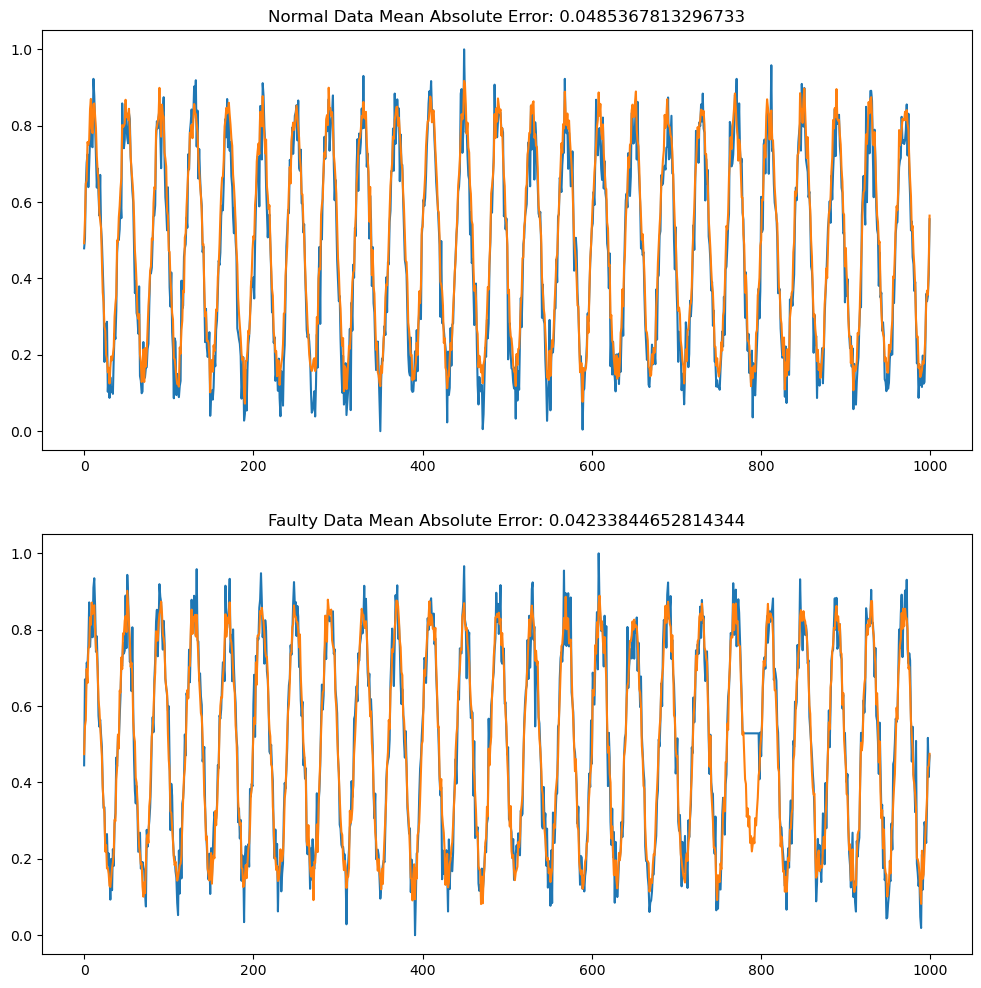

In [ ]:
pca.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 0, 3)

In [ ]:
ae = CreateModel(n_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, f_train_X)
f_train_rec = ae.get_f_rec()
print(f"Threshold Value: {ae.ae_threshold}")
print(f"Total Anomalies out of {ae.samples}: {anomalies}")

32/32 [==============================] - 1s 30ms/step
Threshold Value: [0.0846033  0.03129533 0.0649833  0.05905119 0.05896658 0.05184711
 0.0588885  0.05721563 0.05998718 0.05389292 0.06396615 0.06011139
 0.07773062 0.06188229 0.05478911 0.06030075 0.10415948 0.03848961
 0.03598111 0.06757896 0.06350468 0.09437777 0.08568421 0.0569323
 0.09737722 0.04815979 0.05375324 0.07972328 0.06826143 0.06848316
 0.0582762  0.07002697 0.08246689 0.04308137 0.08329881 0.06659998
 0.03476827 0.08827855 0.07364904 0.03862283 0.07286643 0.06437811
 0.08041142 0.0713348  0.12393464 0.10004019 0.04428201 0.10912933
 0.05555737 0.06526741]
Total Anomalies out of 1000: 65


In [ ]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == ae.ae_threshold)

(array([ 16,  22,  35,  97, 107, 113, 121, 147, 194, 206, 210, 214, 262,
        287, 289, 323, 349, 414, 426, 426, 439, 501, 507, 507, 510, 514,
        545, 584, 607, 630, 642, 654, 667, 681, 683, 702, 715, 772, 815,
        820, 825, 894, 914, 921, 923, 933, 947, 948, 975, 980], dtype=int64),
 array([20, 24, 38,  6, 40, 39,  2, 19, 37, 15, 23,  8, 17, 31,  1,  5,  4,
        28, 13, 14, 36, 32, 41, 48, 47, 45,  9, 44,  3, 29, 26, 49, 11, 10,
        16, 22, 12, 35, 18,  0, 21, 33, 34,  7, 30, 27, 42, 46, 43, 25],
       dtype=int64))

In [ ]:
ae.ae_anomaly

[(29, (array([25], dtype=int64),)),
 (42, (array([23], dtype=int64),)),
 (49, (array([11], dtype=int64),)),
 (62, (array([28], dtype=int64),)),
 (71, (array([32], dtype=int64),)),
 (122, (array([15], dtype=int64),)),
 (141, (array([30], dtype=int64),)),
 (156, (array([25], dtype=int64),)),
 (162, (array([20], dtype=int64),)),
 (169, (array([3], dtype=int64),)),
 (176, (array([33], dtype=int64),)),
 (195, (array([4], dtype=int64),)),
 (197, (array([48], dtype=int64),)),
 (204, (array([9], dtype=int64),)),
 (221, (array([21], dtype=int64),)),
 (244, (array([15], dtype=int64),)),
 (245, (array([26, 43], dtype=int64),)),
 (288, (array([41], dtype=int64),)),
 (300, (array([7], dtype=int64),)),
 (301, (array([5], dtype=int64),)),
 (310, (array([48], dtype=int64),)),
 (326, (array([30], dtype=int64),)),
 (337, (array([38], dtype=int64),)),
 (388, (array([7], dtype=int64),)),
 (402, (array([34], dtype=int64),)),
 (430, (array([25], dtype=int64),)),
 (431, (array([2], dtype=int64),)),
 (460, (a

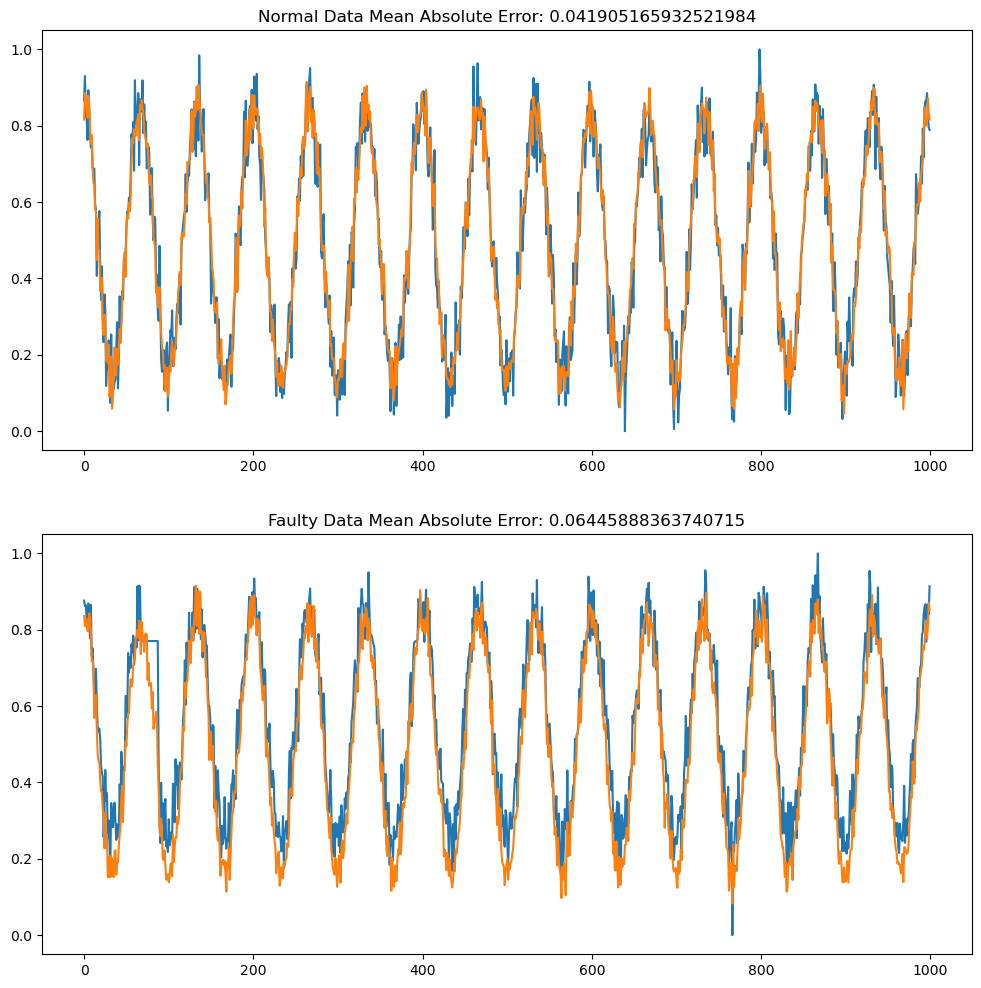

In [ ]:
ae.plot(n_train_X, n_train_rec, f_train_X, f_train_rec, 916, 4)

#### Faulty Data: Contextual Anomaly

In [ ]:
n_data = DataCreation()
n_train_X = n_data.create_samples(samples, features, 2)

f_data = DataCreation()
f_train_X = f_data.create_samples(samples, features, 2)
f_train_X.shape

(1000, 1000, 50)

In [ ]:
# Choose 2 random features

random.seed(1002)
a = [i for i in range(features)]
feature_1 = random.choice(a)
a.remove(feature_1)
feature_2 = random.choice(a)

In [ ]:
# Properties of function for features

co_ef_1 = random.randint(1, 10)
intercept_1 = random.uniform(0, 500)
mean = 0
variance_1 = random.uniform(0.05, 0.1)

co_ef_2 = random.randint(1, 10)
intercept_2 = random.uniform(0, 500)
variance_2 = random.uniform(0.05, 1)

#### Normal Data

In [ ]:
for i in range(samples):
    b = np.array([intercept_1 for i in range(1000)], dtype=object)
    c = np.array([intercept_2 for i in range(1000)], dtype=object)
    ts_1 = random.choice([i for i in range(50, 800)])
    #ts_2 = random.choice([i for i in range(50, ts_1-150)])
    index_1 = [i for i in range(ts_1, ts_1+150)]
    #index_2 = [i for i in range(ts_2, ts_2+150)]
    index_3 = [i for i in range(ts_1-40, ts_1)]
    #index_4 = [i for i in range(ts_2-40, ts_2)]
    b[index_1] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    #b[index_2] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    c[index_3] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    #c[index_4] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    b = b + np.random.normal(mean, variance_1, 1000)
    c = c + np.random.normal(mean, variance_2, 1000)
    n_train_X[i][:, feature_1] = b
    n_train_X[i][:, feature_2] = c
n_train_X = n_data.normalize(n_train_X)

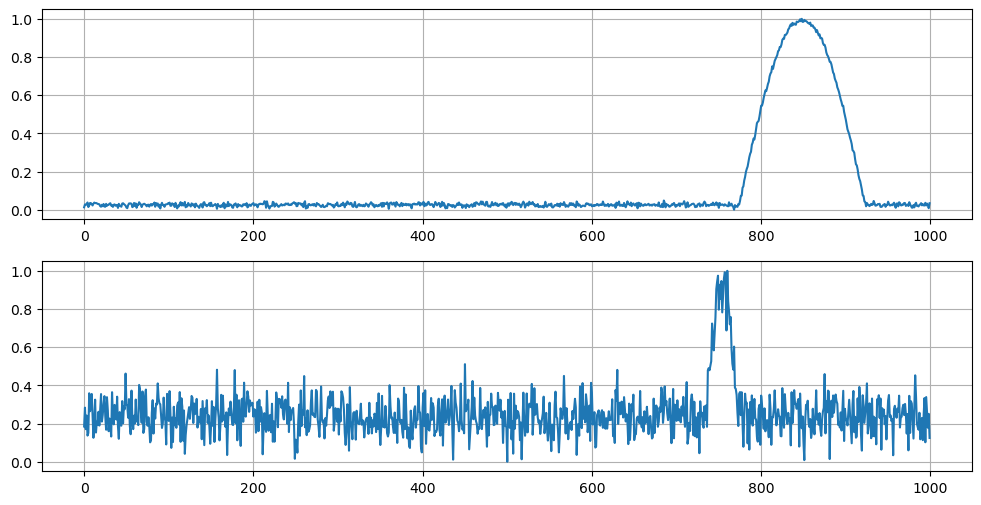

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(n_train_X[2][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(n_train_X[2][:, feature_2])
plt.grid(True)
plt.show()

#### Faulty Data

In [ ]:
for i in range(samples):
    b = np.array([intercept_1 for i in range(1000)], dtype=object)
    c = np.array([intercept_2 for i in range(1000)], dtype=object)
    ts_1 = random.choice([i for i in range(400, 800)])
    ts_2 = random.choice([i for i in range(50, ts_1-150)])
    index_1 = [i for i in range(ts_1-20, ts_1+130)]
    index_2 = [i for i in range(ts_2, ts_2+150)]
    index_3 = [i for i in range(ts_1-40, ts_1)]
    index_4 = [i for i in range(ts_2-40, ts_2)]
    b[index_1] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    b[index_2] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
    c[index_3] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    c[index_4] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
    b = b + np.random.normal(mean, variance_1, 1000)
    c = c + np.random.normal(mean, variance_2, 1000)
    f_train_X[i][:, feature_1] = b
    f_train_X[i][:, feature_2] = c
f_train_X = f_data.normalize(f_train_X)

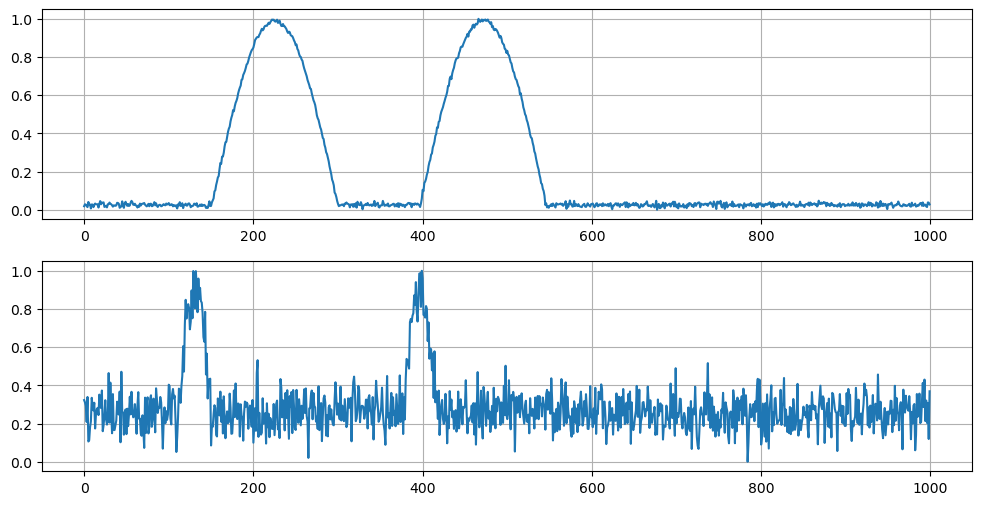

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(f_train_X[2][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(f_train_X[2][:, feature_2])
plt.grid(True)
plt.show()

In [ ]:
pca = CreateModel(n_train_X)
n_train_rec = pca.fit_pca(n_train_X, 15)
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, f_train_X)
f_train_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.pca_threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.1327360518868751
Total Anomalies out of 1000: 0


In [ ]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == pca.pca_threshold)

(array([449], dtype=int64), array([0], dtype=int64))

In [ ]:
pca.pca_anomaly

[]

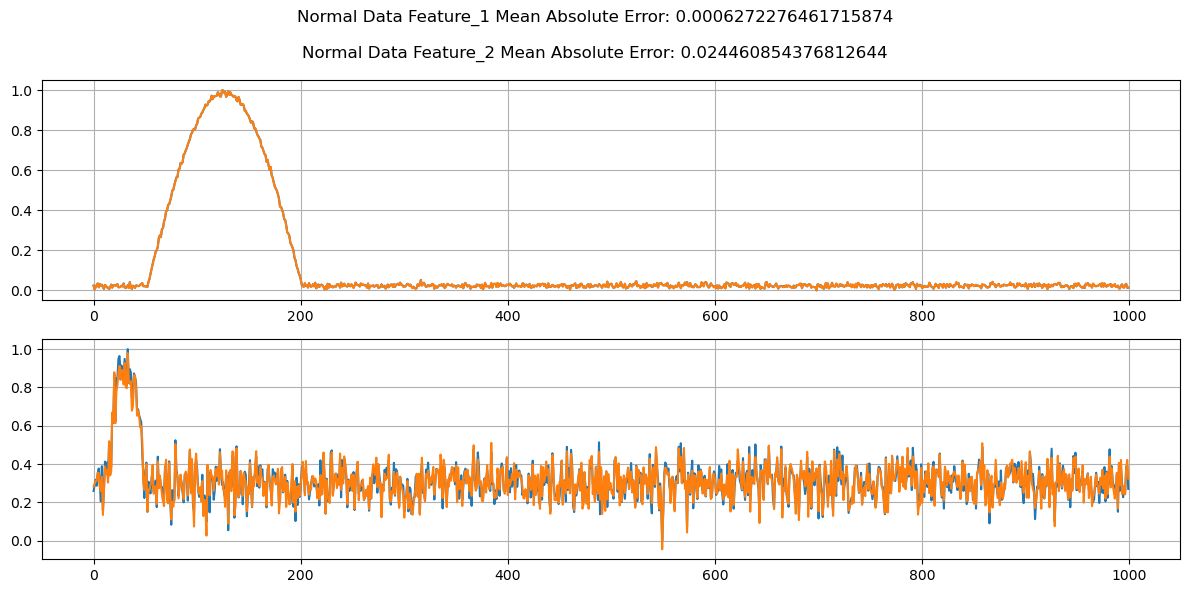

In [ ]:
plt.figure(figsize=(12, 6))
sample = 954
plt.suptitle(f"Normal Data Feature_1 Mean Absolute Error: {mae(n_train_X[sample][:, feature_1], n_train_rec[sample][:, feature_1])}""\n\n"
            f"Normal Data Feature_2 Mean Absolute Error: {mae(n_train_X[sample][:, feature_2], n_train_rec[sample][:, feature_2])}")
plt.subplot(211)
plt.plot(n_train_X[sample][:, feature_1])
plt.plot(n_train_rec[sample][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(n_train_X[sample][:, feature_2])
plt.plot(n_train_rec[sample][:, feature_2])
plt.grid(True)
plt.tight_layout()
plt.show()

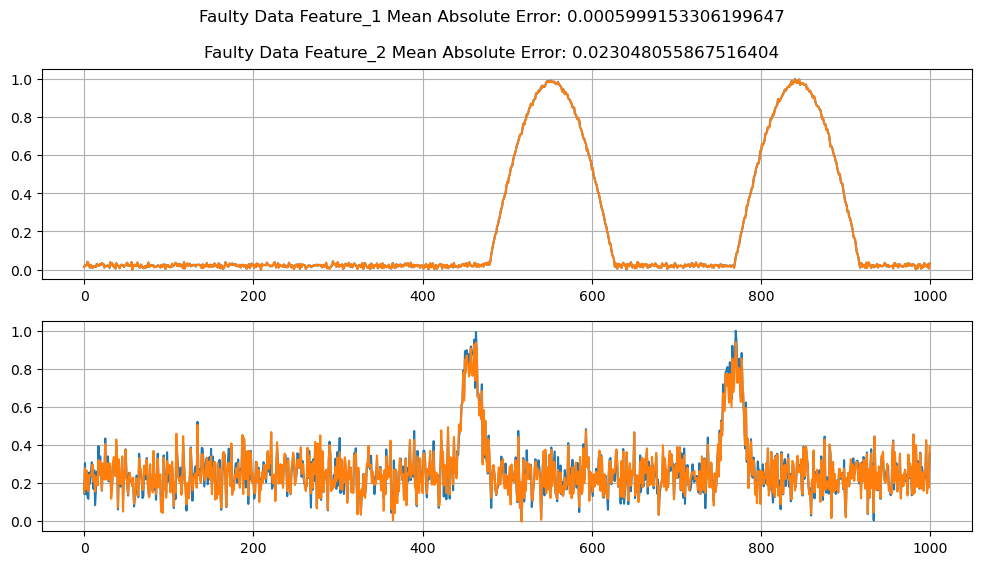

In [ ]:
plt.figure(figsize=(12, 6))
sample = 0
plt.suptitle(f"Faulty Data Feature_1 Mean Absolute Error: {mae(f_train_X[2][:, feature_1], f_train_rec[2][:, feature_1])}""\n\n"
            f"Faulty Data Feature_2 Mean Absolute Error: {mae(f_train_X[2][:, feature_2], f_train_rec[2][:, feature_2])}")
plt.subplot(211)
plt.plot(f_train_X[sample][:, feature_1])
plt.plot(f_train_rec[sample][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(f_train_X[sample][:, feature_2])
plt.plot(f_train_rec[sample][:, feature_2])
plt.grid(True)
plt.show()

In [ ]:
ae = CreateModel(n_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, f_train_X)
f_train_rec = ae.get_f_rec()
print(f"Threshold Value: {ae.ae_threshold}")
print(f"Total Anomalies out of {ae.samples}: {anomalies}")

32/32 [==============================] - 1s 33ms/step
Threshold Value: 0.12348713183372131
Total Anomalies out of 1000: 1


In [ ]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == ae.ae_threshold)

(array([449], dtype=int64), array([0], dtype=int64))

In [ ]:
ae.ae_anomaly

[(304, (array([21], dtype=int64),))]

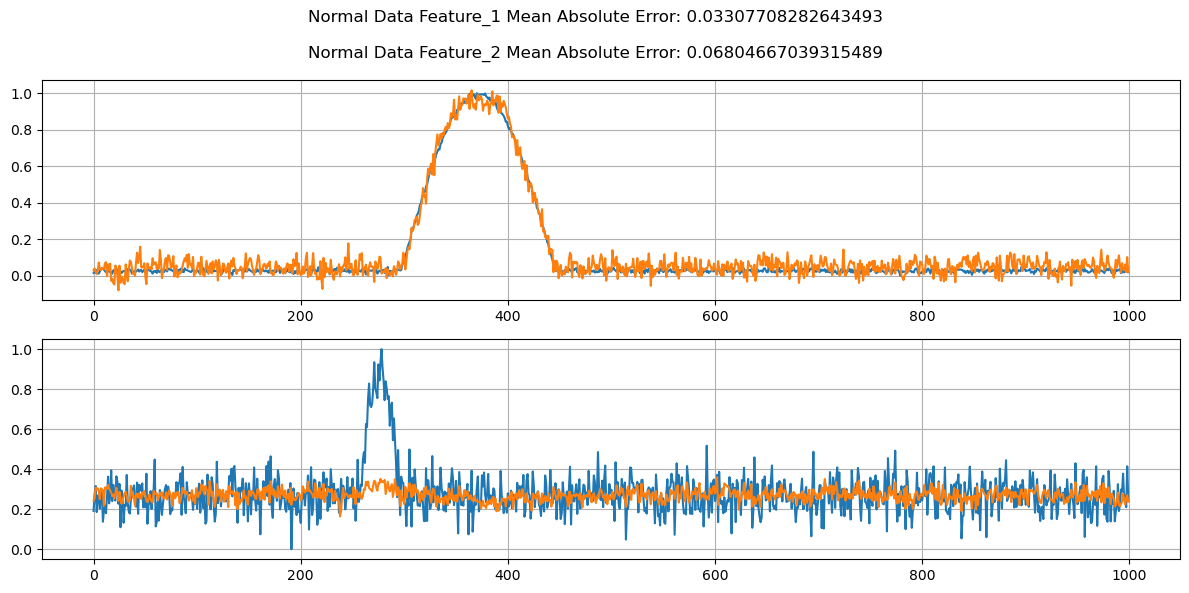

In [ ]:
plt.figure(figsize=(12, 6))
sample = 6
plt.suptitle(f"Normal Data Feature_1 Mean Absolute Error: {mae(n_train_X[sample][:, feature_1], n_train_rec[sample][:, feature_1])}""\n\n"
            f"Normal Data Feature_2 Mean Absolute Error: {mae(n_train_X[sample][:, feature_2], n_train_rec[sample][:, feature_2])}")
plt.subplot(211)
plt.plot(n_train_X[sample][:, feature_1])
plt.plot(n_train_rec[sample][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(n_train_X[sample][:, feature_2])
plt.plot(n_train_rec[sample][:, feature_2])
plt.grid(True)
plt.tight_layout()
plt.show()

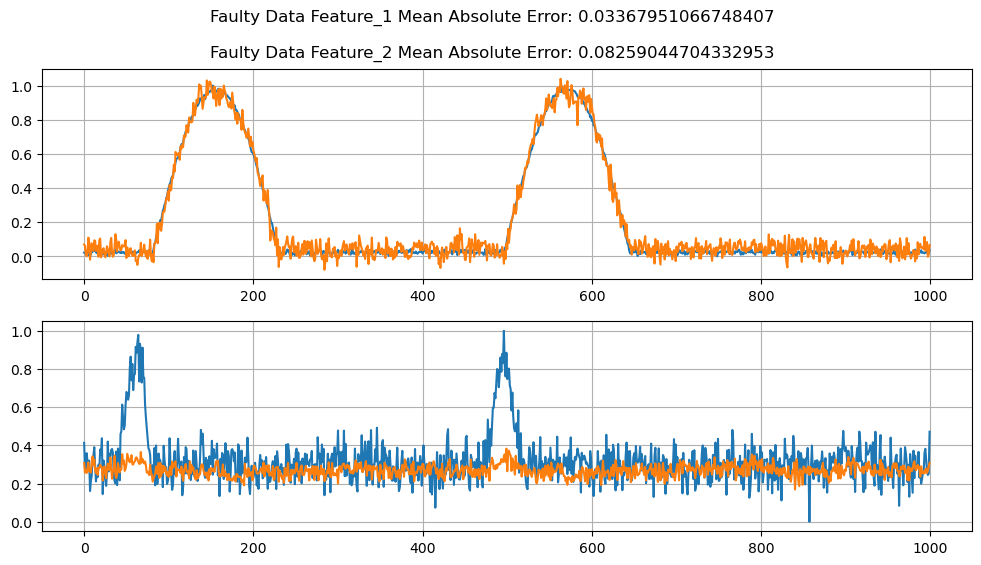

In [ ]:
plt.figure(figsize=(12, 6))
sample = 5
plt.suptitle(f"Faulty Data Feature_1 Mean Absolute Error: {mae(f_train_X[sample][:, feature_1], f_train_rec[sample][:, feature_1])}""\n\n"
            f"Faulty Data Feature_2 Mean Absolute Error: {mae(f_train_X[sample][:, feature_2], f_train_rec[sample][:, feature_2])}")
plt.subplot(211)
plt.plot(f_train_X[sample][:, feature_1])
plt.plot(f_train_rec[sample][:, feature_1])
plt.grid(True)
plt.subplot(212)
plt.plot(f_train_X[sample][:, feature_2])
plt.plot(f_train_rec[sample][:, feature_2])
plt.grid(True)
plt.show()

### Testing with Normal Data

In [ ]:
n_data0 = DataCreation()
n_train_X = n_data0.create_samples(samples, features, 2)
n_train_X = n_data0.normalize(n_train_X)

n_data1 = DataCreation()
n_test = n_data1.create_samples(samples, features, 2)
n_test = n_data1.normalize(n_test)
n_test.shape

(1000, 1000, 50)

In [ ]:
pca = CreateModel(n_train_X)
n_train_rec = pca.fit_pca(n_train_X, 25)
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, n_test)
n_test_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.pca_threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.0698239078248732
Total Anomalies out of 1000: 0


In [ ]:
a = np.mean(np.abs(n_train_X - n_train_rec), axis=1)
np.where(a == pca.pca_threshold)

(array([446], dtype=int64), array([35], dtype=int64))

In [ ]:
pca.pca_anomaly

[]

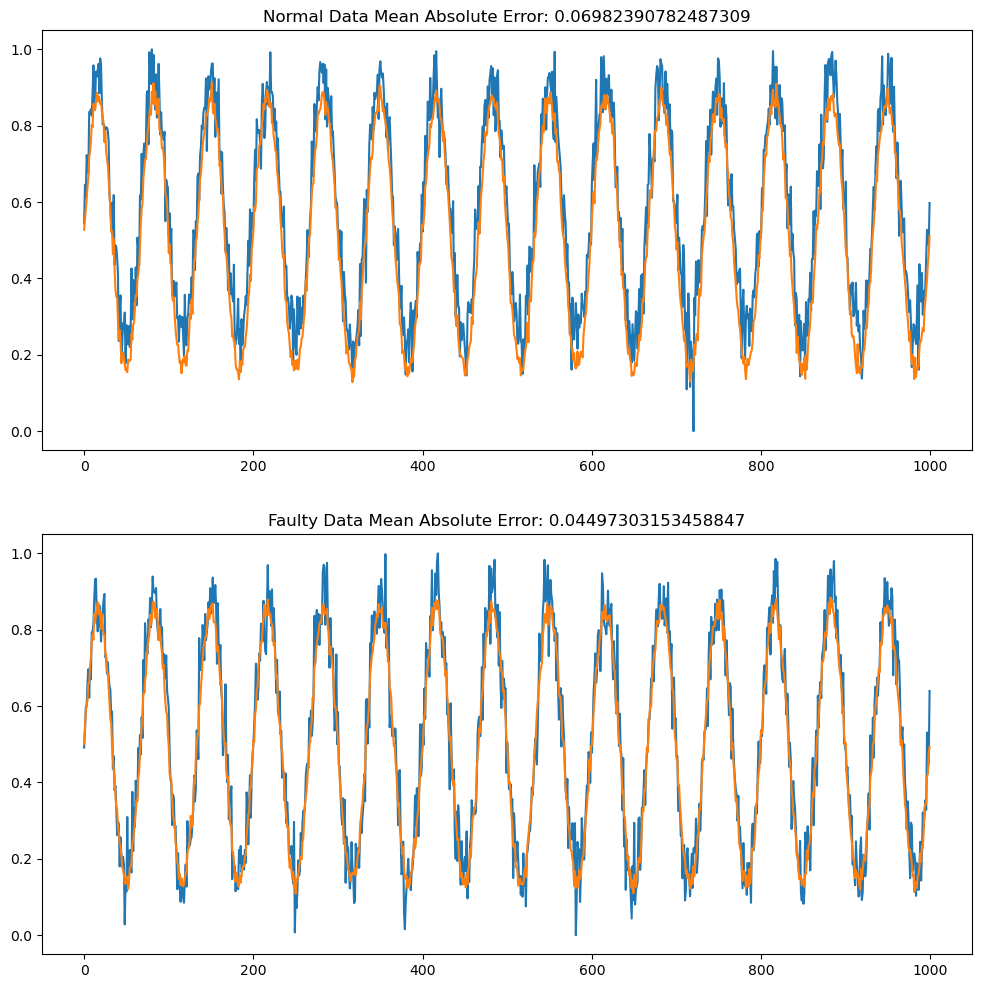

In [ ]:
pca.plot(n_train_X, n_train_rec, n_test, n_test_rec, 446, 35)

In [ ]:
ae = CreateModel(n_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, n_test)
n_test_rec = ae.get_f_rec()
print(f"Threshold Value: {ae.ae_threshold}")
print(f"Total Anomalies out of {ae.samples}: {anomalies}")

32/32 [==============================] - 1s 29ms/step
Threshold Value: 0.07053882015022649
Total Anomalies out of 1000: 24


In [ ]:
n_data0 = DataCreation()
n_train_X = n_data0.create_samples(samples, features, 2)

n_data1 = DataCreation()
n_test = n_data1.create_samples(samples, features, 2)
n_test.shape

(1000, 1000, 50)

In [ ]:
# Choose 2 random features

random.seed(1003)
a = [i for i in range(50)]
feature_1 = random.choice(a)
a.remove(feature_1)
feature_2 = random.choice(a)

In [ ]:
# Properties of function for features

co_ef_1 = random.randint(1, 10)
intercept_1 = random.uniform(0, 500)
mean = 0
variance_1 = random.uniform(0.05, 0.1)

co_ef_2 = random.randint(1, 10)
intercept_2 = random.uniform(0, 500)
variance_2 = random.uniform(0.05, 1)

In [ ]:
for df in ([n_train_X, n_test]):
    for i in range(1000):
        b = np.array([intercept_1 for i in range(1000)], dtype=object)
        c = np.array([intercept_2 for i in range(1000)], dtype=object)
        ts_1 = random.choice([i for i in range(400, 800)])
        ts_2 = random.choice([i for i in range(50, ts_1-150)])
        index_1 = [i for i in range(ts_1, ts_1+150)]
        index_2 = [i for i in range(ts_2, ts_2+150)]
        index_3 = [i for i in range(ts_1-40, ts_1)]
        index_4 = [i for i in range(ts_2-40, ts_2)]
        b[index_1] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
        b[index_2] = co_ef_1 * np.sin(np.linspace(0, np.pi, 150)) + intercept_1
        c[index_3] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
        c[index_4] = co_ef_2 * np.sin(np.linspace(0, np.pi, 40)) + intercept_2
        b = b + np.random.normal(mean, variance_1, 1000)
        c = c + np.random.normal(mean, variance_2, 1000)
        df[i][:, feature_1] = b
        df[i][:, feature_2] = c
n_train_X = n_data.normalize(n_train_X)
n_test = n_data.normalize(n_test)

In [ ]:
pca = CreateModel(n_train_X)
n_train_rec = pca.fit_pca(n_train_X, 5)
anomalies = pca.evaluate_pca(n_train_X, n_train_rec, n_test)
n_test_rec = pca.get_f_rec()
print(f"Threshold Value: {pca.pca_threshold}")
print(f"Total Anomalies out of {pca.samples}: {anomalies}")

Threshold Value: 0.07488022439536972
Total Anomalies out of 1000: 486


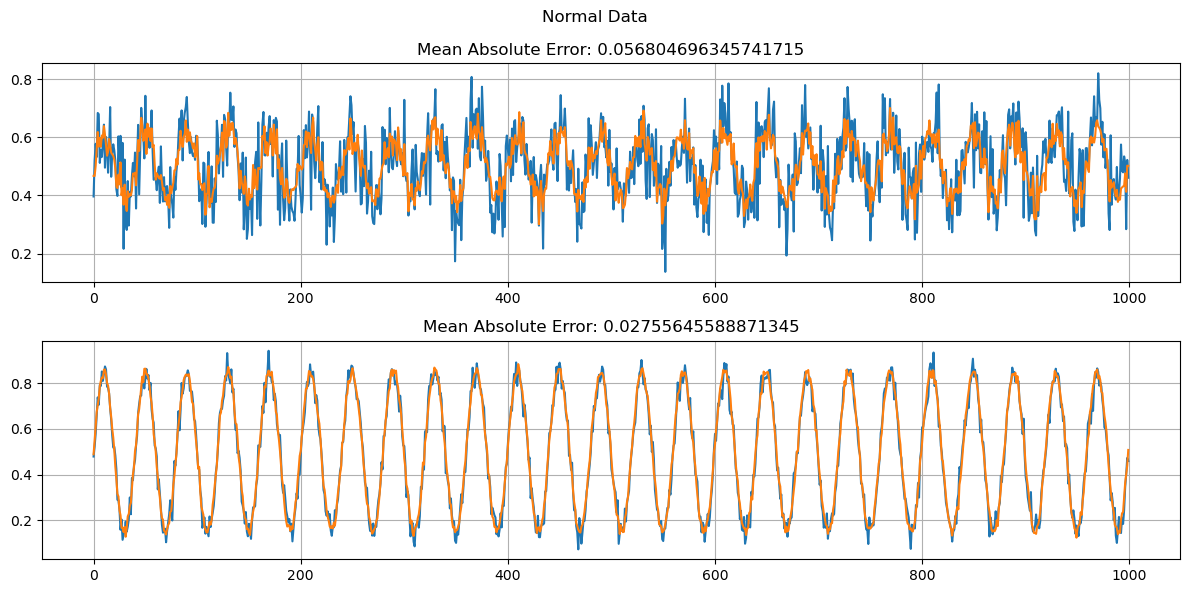

In [ ]:
plt.figure(figsize=(12, 6))
plt.suptitle("Normal Data")
plt.subplot(211)
plt.title(f"Mean Absolute Error: {mae(n_train_X[2][:, 0], n_train_rec[2][:, 0])}")
plt.plot(n_train_X[2][:, 0])
plt.plot(n_train_rec[2][:, 0])
plt.grid(True)
plt.subplot(212)
plt.title(f"Mean Absolute Error: {mae(n_train_X[2][:, 1], n_train_rec[2][:, 1])}")
plt.plot(n_train_X[2][:, 1])
plt.plot(n_train_rec[2][:, 1])
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
ae = CreateModel(n_train_X)
n_train_rec = ae.fit_ae(n_train_X)
anomalies = ae.evaluate_ae(n_train_X, n_train_rec, n_test)
n_test_rec = ae.get_f_rec()
print(f"Threshold Value: {ae.ae_threshold}")
print(f"Total Anomalies out of {ae.samples}: {anomalies}")

32/32 [==============================] - 1s 28ms/step
Threshold Value: 0.06679229884765987
Total Anomalies out of 1000: 457
